# 온도 예제

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


데이터 프레임의 경우도 호환이 되긴 하지만 Series의 경우가 제일 안전

In [5]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

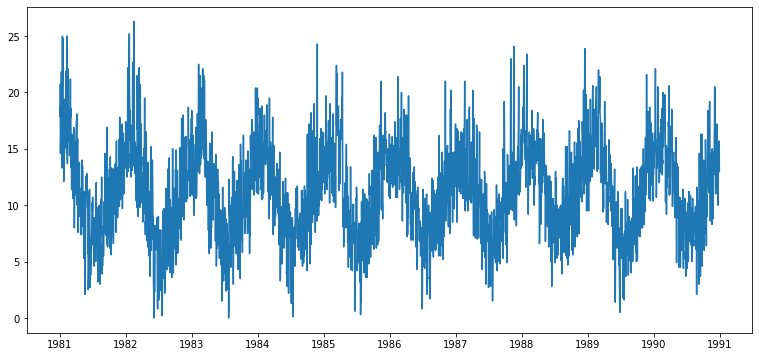

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

In [7]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

결측치를 삭제하거나, 양옆의 값을 이용해 보간해보기  
결측치 처리에 간한 메서드  
[결측치 참조](https://rfriend.tistory.com/264)

Series([], Name: Temp, dtype: float64)


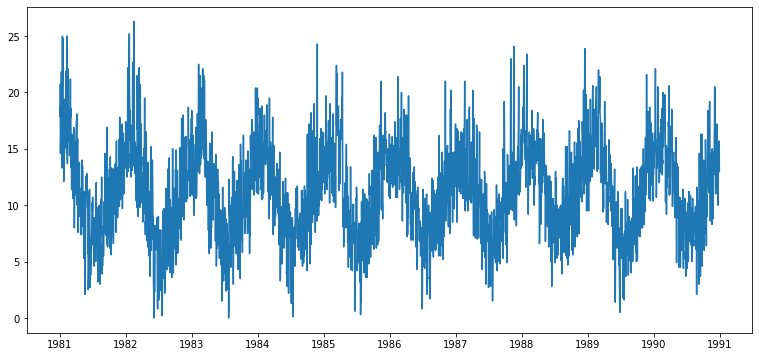

In [8]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

구간 통계치(Rolling Statistics)란 현재 타임 스텝부터 window에 주어진 타임스텝에 대해  
1. 구간의 평균(Rolling mean, 이동평균)
2. 표준편차(Rolling std, 이동표준편차)  을 구해보는 것  
[참조글](https://www.econowide.com/3544)

In [17]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

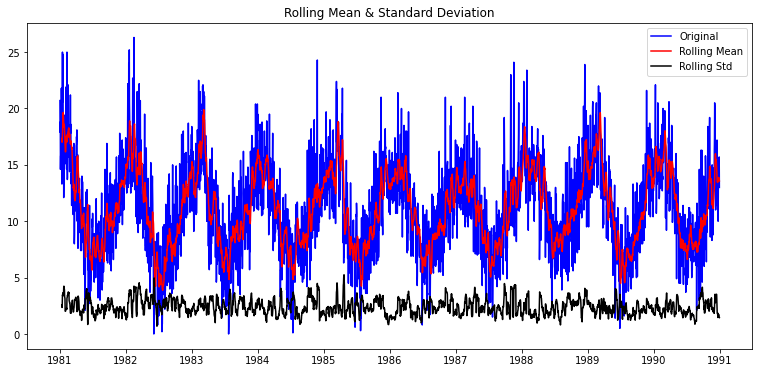

In [10]:
plot_rolling_statistics(ts1, window=12)

# Airline Passenger 예제

In [11]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


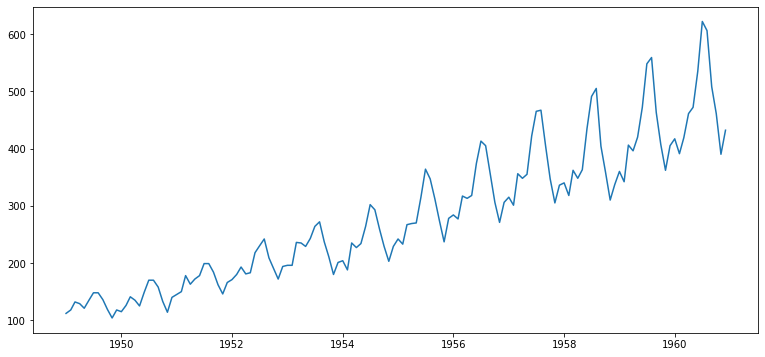

In [12]:
ts2 = df['Passengers']
plt.plot(ts2)

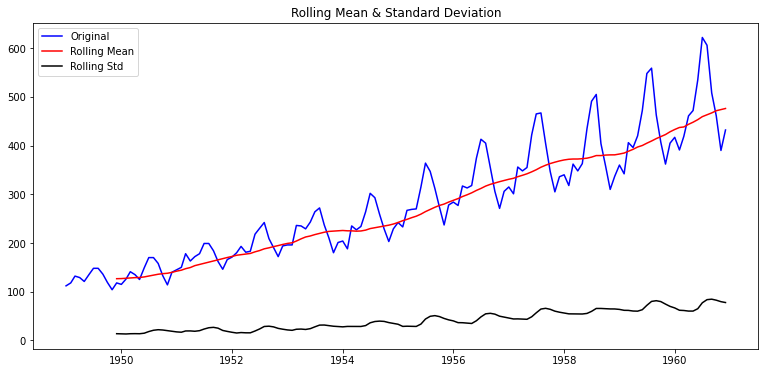

In [13]:
plot_rolling_statistics(ts2, window=12)

## statsmodels, adfuller

In [19]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [15]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


시계열이 안정적이지 않다는 귀무가설의 p-value가 1에 가까운데  
이는 직접적으로 안정적이지 않다는 말은 아니지만 귀무가설을 기각할 수 없으므로 아직 안정적인 시계열이라고 말할 수 없음

stationary한 특성을 가지도록 할 수 있는 방법  
1. 정성분석을 통해 안정적인 특성을 가지도록 기존의 시계열 데이터 가공/변형  
2. 시계열 분해(Time series decomposition)기법 적용

시간 추이에 따라 분산이 커지므로 로그함수 변환 시도

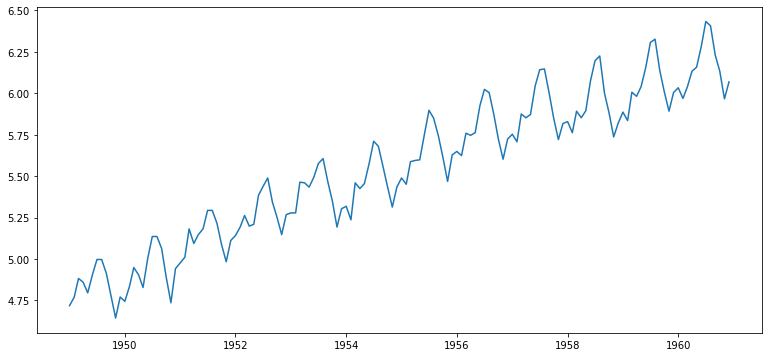

In [16]:
# 로그함수 변환
ts_log = np.log(ts2)
plt.plot(ts_log)

In [17]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value가 0.42로 감소 확인

Moving average 제거 - 추세(trend) 상쇄

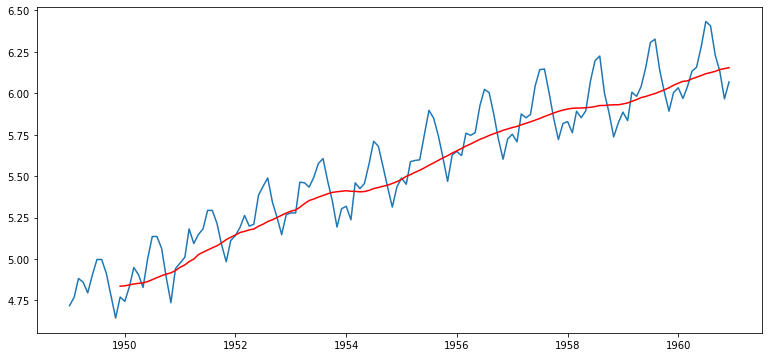

In [18]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [19]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

window size가 12의 경우 앞 11개 데이터가 결측치로 되면서 추후 dicky-Fuller test 에러를 발생시킬 수 있으므로 제거

In [20]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

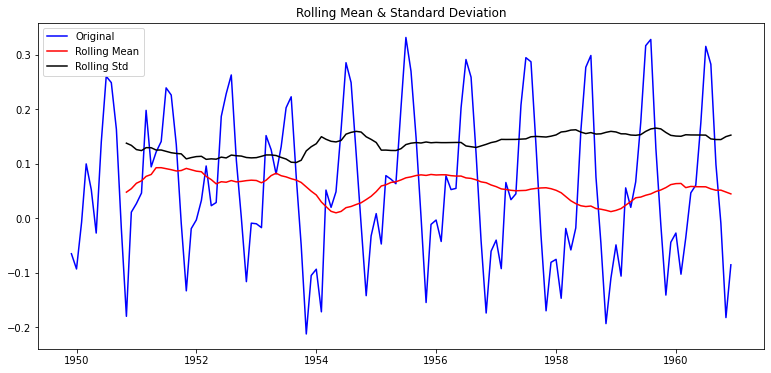

In [21]:
plot_rolling_statistics(ts_log_moving_avg)

In [22]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


p-value가 0.02수준으로 95% 이상의 confidence로 time series는 stationary한 상태  

window 사이즈가 바뀐다면?

In [24]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

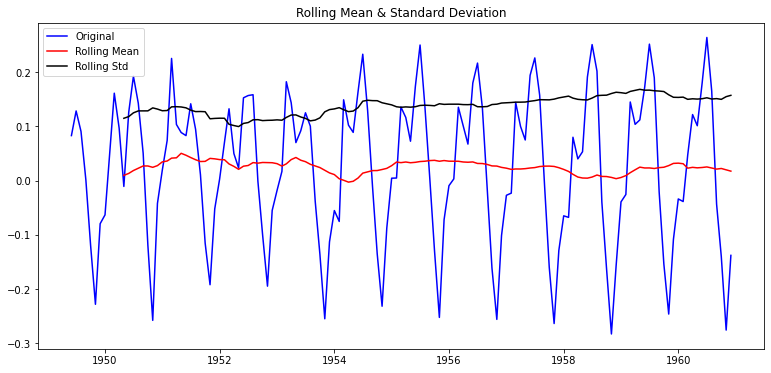

In [25]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [26]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


p-value가 0.18 수준으로 안정적이지 않음  
데이터셋이 월단위로 발생하는 시계열이므로 12개월 주기성이 있기 때문에 window size가 12로 했을때 효과 나는것으로 추측을 해볼만 함

차분(diffrencing) - 계절성(seasonality) 상쇄하기  
trend에 잡히지 않지만 데이터 안에 포함되었으나, 패턴이 파악되지 않은 주기적인 변화는 예측에 방해가 되는 불안정성 요소로 계절성이 존재

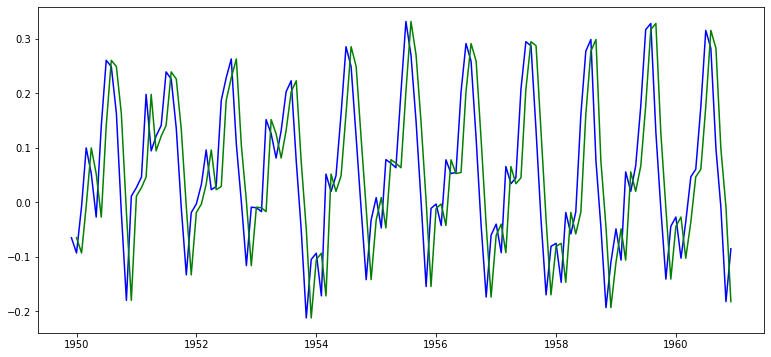

In [27]:
# 시프트한 시계열과 원본 시계열에 대한 그래프
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

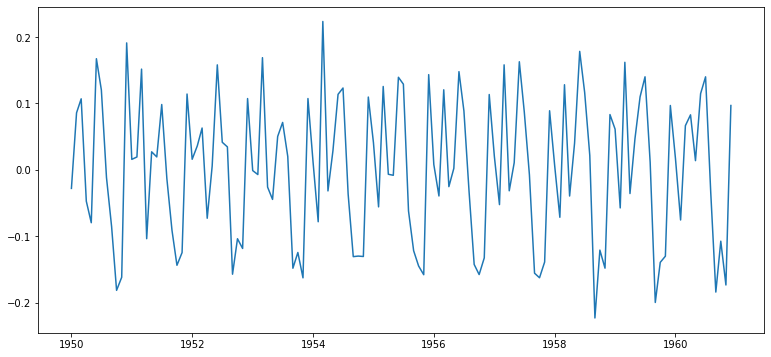

In [28]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

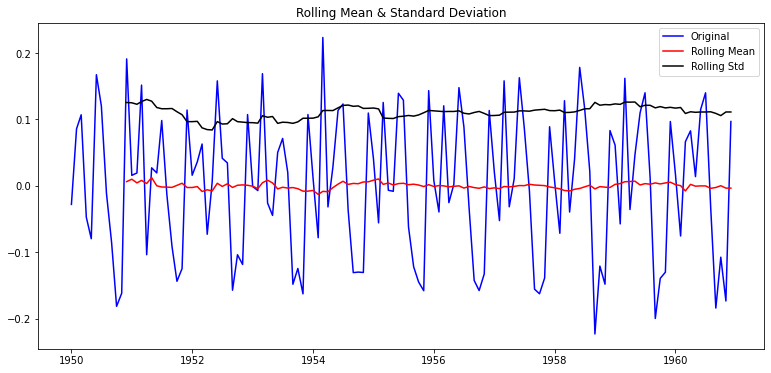

In [29]:
# 
plot_rolling_statistics(ts_log_moving_avg_diff)

In [30]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


## 시계열 분해

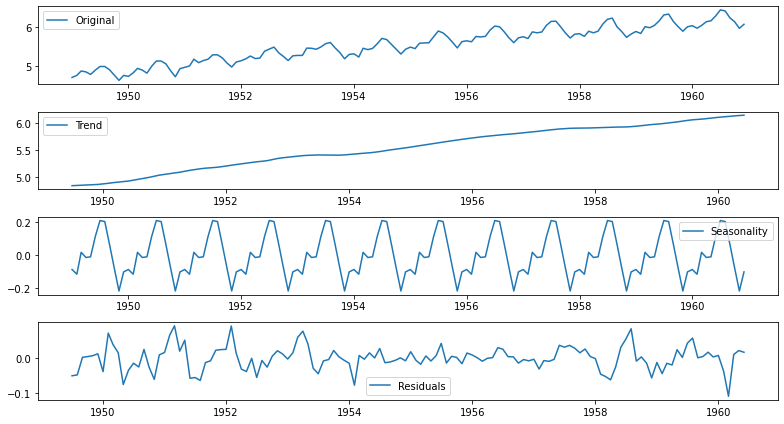

In [31]:
# seasonal_decompose 사용 효과적인 예시
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

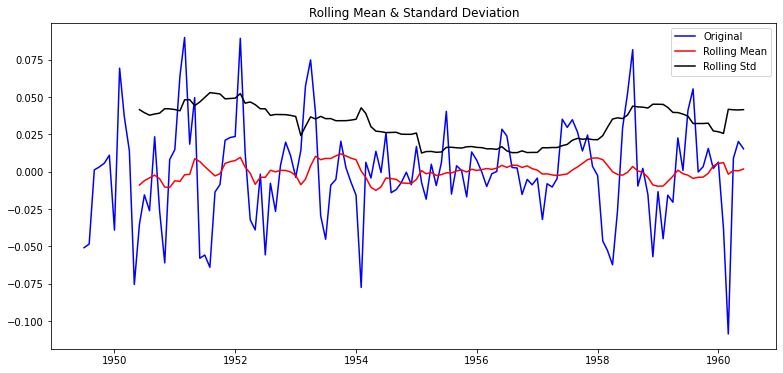

In [32]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [33]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


# ARIMA

시계열 데이터의 Trend, Seasonality, Residual로 분해할 수 있고  
Trend와 Seasonality를 분리하면 Residual이 예측력 있는 안정적 시계열 데이터가 됨  
ARIMA(Autoregressive Integreated Moving Average)를 사용하면 시계열 데이터 예측 모델 자동으로 만들기 가능  

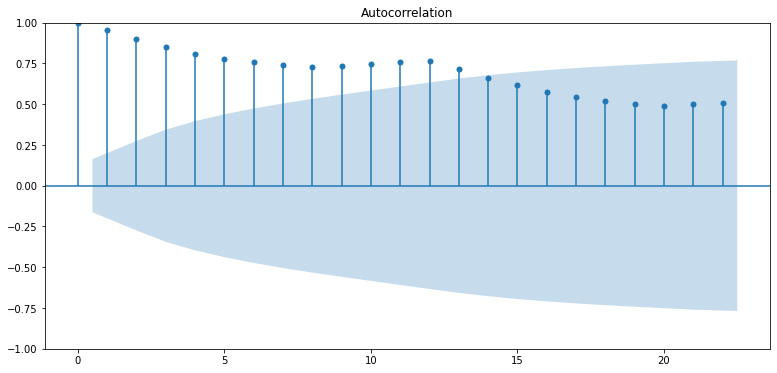

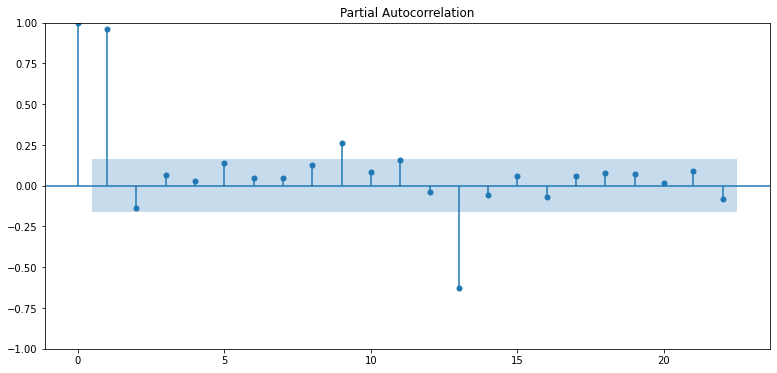

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

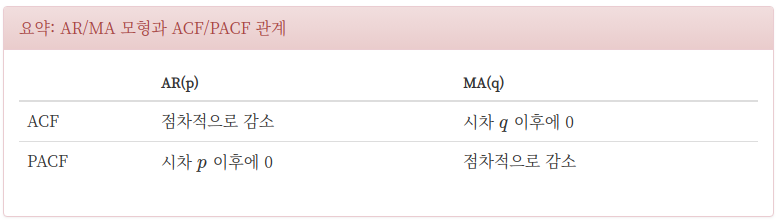

위 그림으로 보아 PACF 그래프를 보면 p=1이 적합해 보이며, 2 이상인 구간에선 PACF가 거의 0에 가까워 지고 있음  
이는 p 시점 떨어진 이전의 데이터는 상관도가 0으로 고려할 필요가 없음   
반면 ACF는 점차 감소해서 AR(1) 유사 형태를 보이며, q에 대해서는 적절한 값이 안보여 q=0으로 둘 수 있지만 값을 바꿔볼 필요는 있음

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


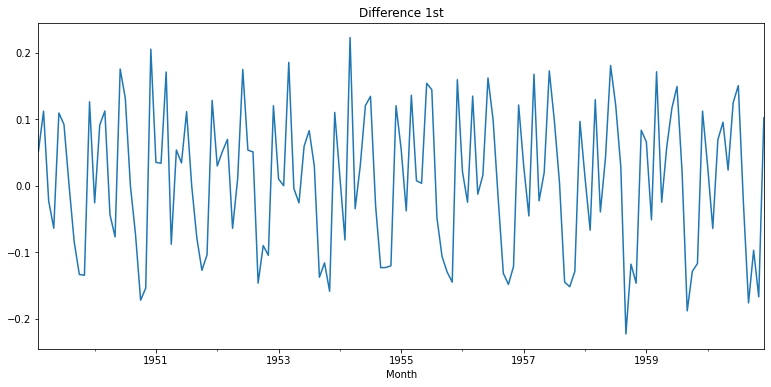

In [35]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


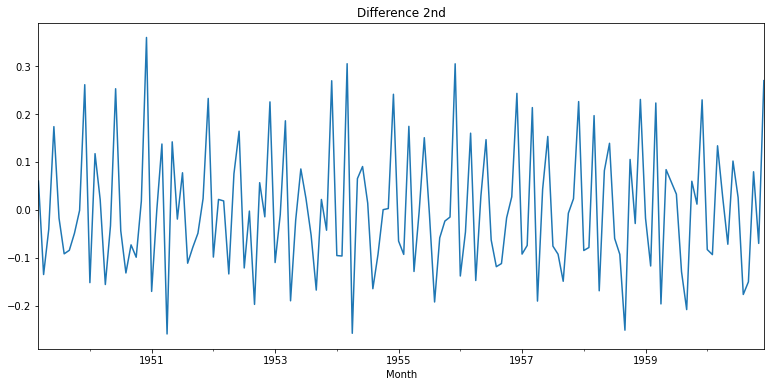

In [36]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 학습데이터 분리

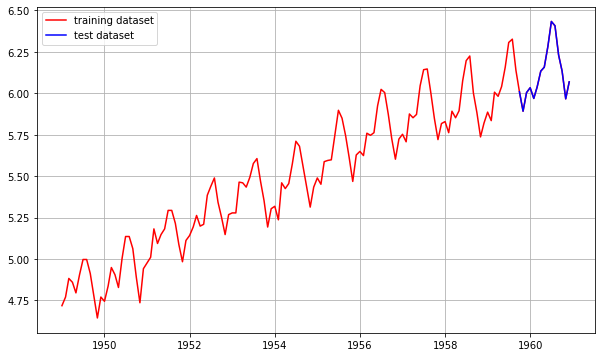

In [37]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [38]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


모수 참고자료  
[자기상관함수 및 편자기상관함수](http://kanggc.iptime.org/em/chap9/chap9.pdf)  
[A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

# 훈련 및 추론

In [39]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.951
Date:                Thu, 10 Feb 2022   AIC                           -409.902
Time:                        13:03:34   BIC                           -367.121
Sample:                    01-01-1949   HQIC                          -392.520
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2752      0.081     -3.387      0.001      -0.434      -0.116
ar.L2         -0.0124      0.109     -0.114      0.909      -0.225       0.200
ar.L3          0.0002      0.046      0.005      0.9

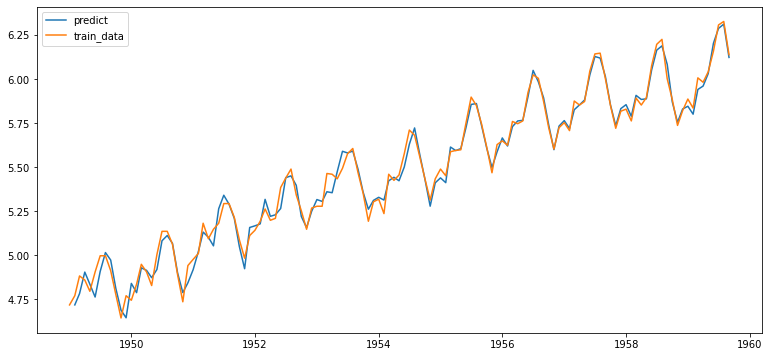

In [40]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

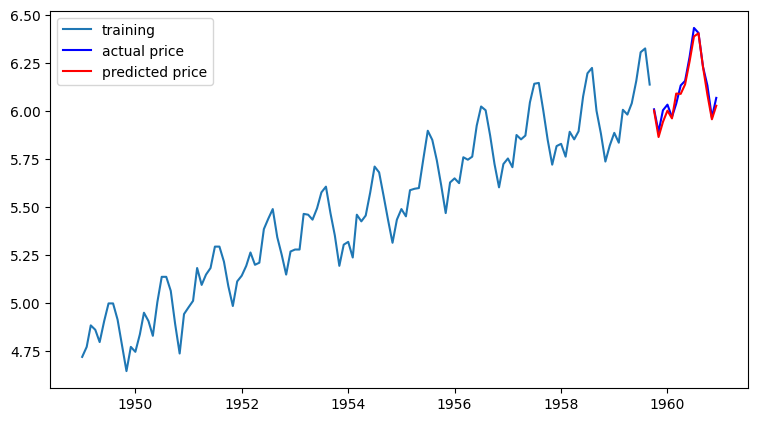

In [41]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  231.97320956929948
MAE:  12.424959605677085
RMSE:  15.230666747365314
MAPE: 2.74%


# 프로젝트 주식 예측

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
df = pd.read_csv('~/aiffel/stock_prediction/data/005930.KS.csv')

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [9]:
close = df.Close

In [15]:
# 결측치 확인
close.isna().sum()

0

In [16]:
# 로그변환
log_close = np.log(close)
log_close.head()

0    10.795486
1    10.825760
2    10.819778
3    10.818778
4    10.794460
Name: Close, dtype: float64

정성적 그래프 분석

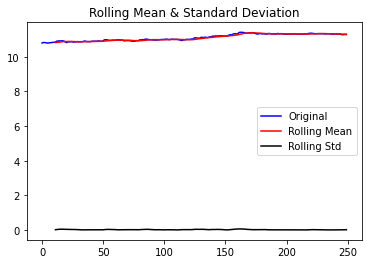

In [18]:
plot_rolling_statistics(log_close, window=12)

정량적 Augmented Dicky-Fuller Test

In [20]:
augmented_dickey_fuller_test(log_close)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


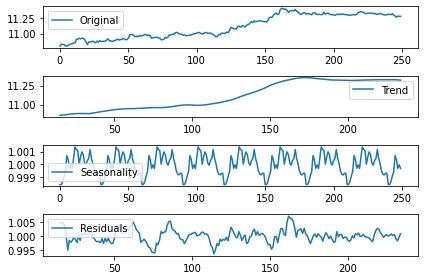

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_close, model='multiplicative',period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(log_close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Residual 확인

In [26]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


데이터셋 분리

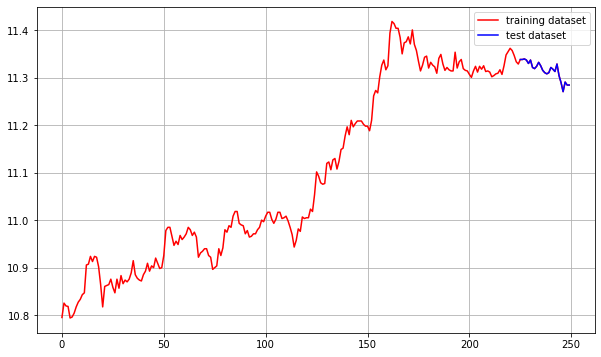

In [30]:
train_data, test_data = log_close[:int(len(log_close)*0.9)], log_close[int(len(log_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(log_close, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


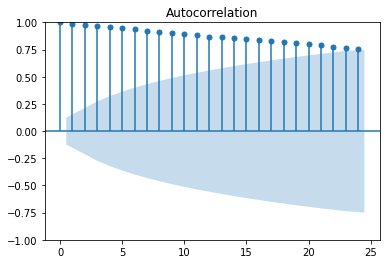

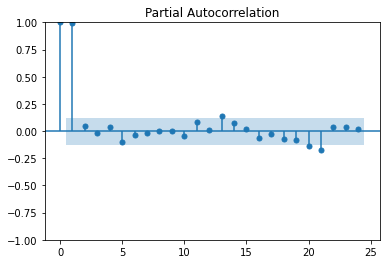

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(log_close) #autocorrelation
plot_pacf(log_close) #partial autocorrelation
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


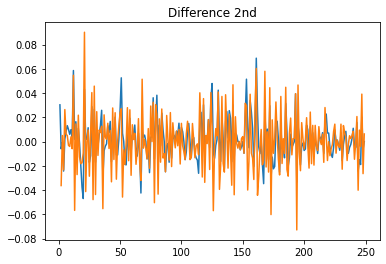

In [34]:
# 1차 차분
diff_1 = log_close.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [35]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 10 Feb 2022   AIC                          -1156.722
Time:                        23:39:44   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

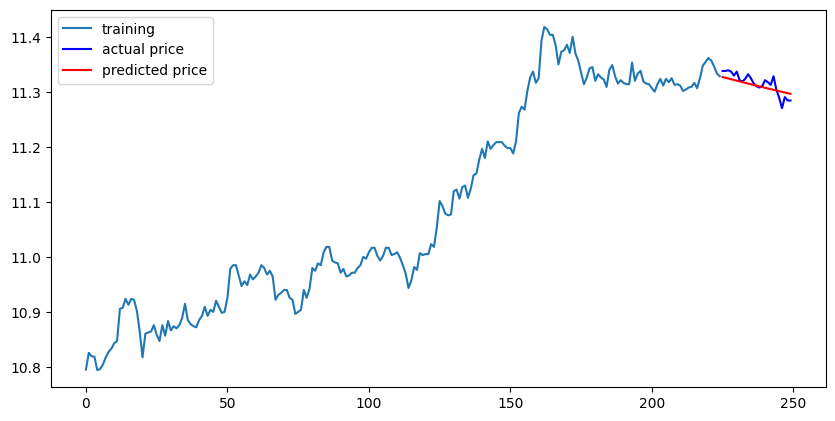

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


In [39]:
pip install finance-datareader

Note: you may need to restart the kernel to use updated packages.


In [40]:
import FinanceDataReader as fdr

df = fdr.DataReader('USD/KRW', '2010')
print(df)

              Close     Open     High      Low  Change
Date                                                  
2010-01-01  1166.08  1166.08  1166.08  1166.08  0.0000
2010-01-04  1150.00  1164.07  1164.07  1149.35 -0.0138
2010-01-05  1140.20  1151.00  1151.00  1136.30 -0.0085
2010-01-06  1129.20  1140.20  1144.70  1129.20 -0.0096
2010-01-07  1138.20  1129.20  1138.20  1127.80  0.0080
...             ...      ...      ...      ...     ...
2022-02-04  1198.25  1200.65  1202.05  1196.81 -0.0010
2022-02-07  1196.87  1199.00  1201.09  1196.72 -0.0012
2022-02-08  1196.35  1196.92  1200.38  1196.21 -0.0004
2022-02-09  1194.05  1196.40  1197.47  1193.02 -0.0019
2022-02-10  1200.51  1194.18  1201.16  1193.58  0.0054

[3160 rows x 5 columns]


In [41]:
er_close = df.Close

결측치 확인

In [45]:
er_close.isna().sum()

0

로그 변환

In [46]:
log_erclose = np.log(er_close)

정성적 그래프 분석

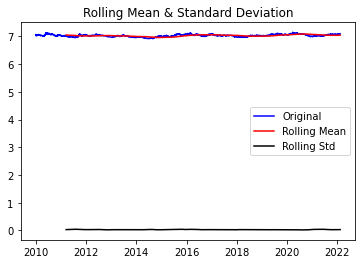

In [53]:
# 10년 데이터, 3160 / 10
plot_rolling_statistics(log_erclose, window=316)

In [54]:
augmented_dickey_fuller_test(log_erclose)

Results of Dickey-Fuller Test:
Test Statistic                   -3.285991
p-value                           0.015516
#Lags Used                        1.000000
Number of Observations Used    3158.000000
Critical Value (1%)              -3.432422
Critical Value (5%)              -2.862456
Critical Value (10%)             -2.567257
dtype: float64


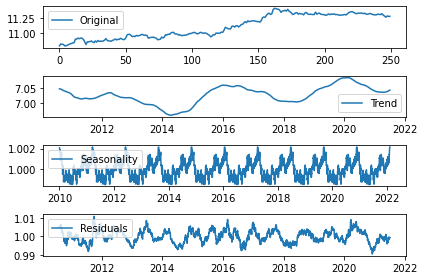

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_erclose, model='multiplicative',period=316)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(log_close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Residual 확인

In [57]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                   -5.382406
p-value                           0.000004
#Lags Used                        1.000000
Number of Observations Used    2842.000000
Critical Value (1%)              -3.432653
Critical Value (5%)              -2.862558
Critical Value (10%)             -2.567312
dtype: float64


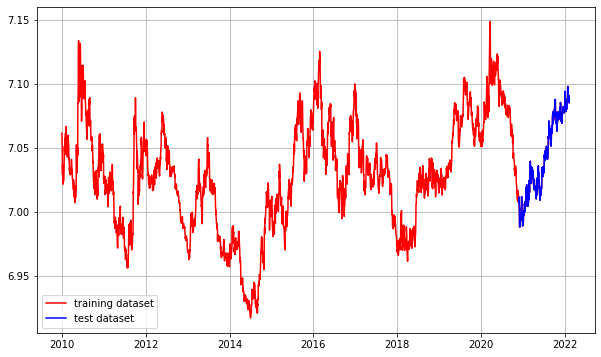

In [61]:
train_data, test_data = log_erclose[:int(len(log_erclose)*0.9)], log_erclose[int(len(log_erclose)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(log_erclose, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


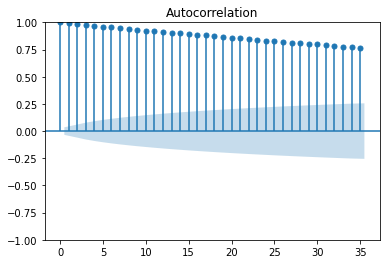

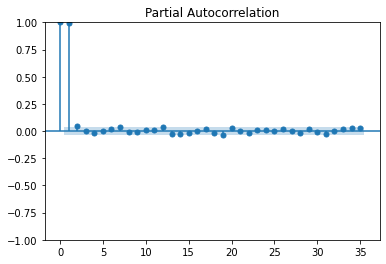

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(log_erclose) #autocorrelation
plot_pacf(log_erclose) #partial autocorrelation
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -58.612971
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    3158.000000
Critical Value (1%)              -3.432422
Critical Value (5%)              -2.862456
Critical Value (10%)             -2.567257
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.820035e+01
p-value                        2.406742e-30
#Lags Used                     2.900000e+01
Number of Observations Used    3.128000e+03
Critical Value (1%)           -3.432442e+00
Critical Value (5%)           -2.862464e+00
Critical Value (10%)          -2.567262e+00
dtype: float64


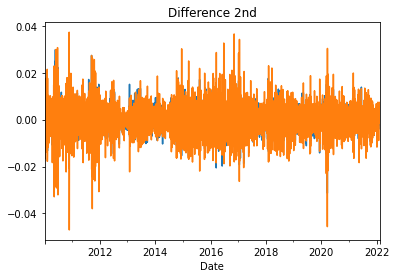

In [84]:
# 1차 차분
diff_1 = log_erclose.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2844
Model:                 ARIMA(2, 0, 1)   Log Likelihood               10811.760
Date:                Fri, 11 Feb 2022   AIC                         -21613.521
Time:                        01:28:14   BIC                         -21583.756
Sample:                    01-01-2010   HQIC                        -21602.785
                         - 11-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0274      0.013    528.254      0.000       7.001       7.053
ar.L1          0.8866      0.389      2.278      0.023       0.124       1.650
ar.L2          0.1050      0.386      0.272      0.7

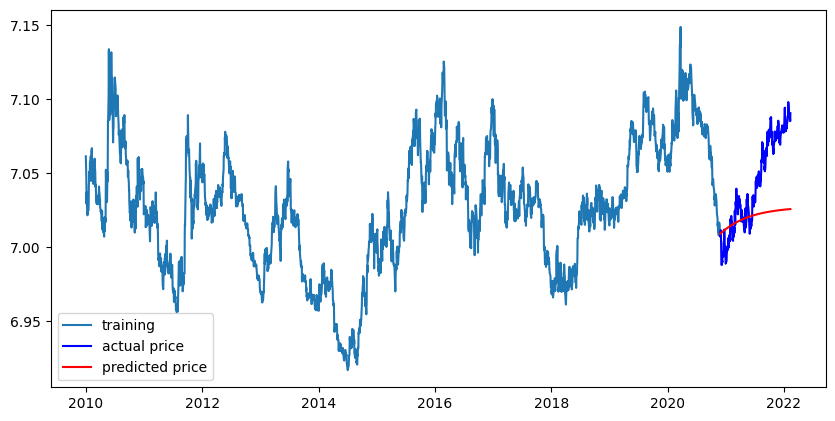

MSE:  1611.3316206597517
MAE:  31.491101511173355
RMSE:  40.14139535018373
MAPE: 2.69%


In [86]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit()
print(fitted_m.summary())
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2844
Model:                 ARIMA(2, 0, 2)   Log Likelihood               10811.721
Date:                Fri, 11 Feb 2022   AIC                         -21611.443
Time:                        01:33:52   BIC                         -21575.725
Sample:                    01-01-2010   HQIC                        -21598.560
                         - 11-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0274      0.013    525.250      0.000       7.001       7.054
ar.L1          0.6835      4.586      0.149      0.882      -8.305       9.672
ar.L2          0.3067      4.552      0.067      0.9

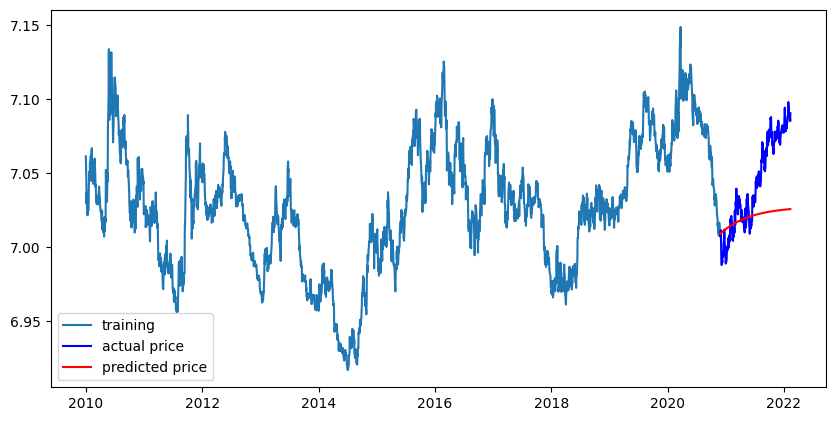

MSE:  1613.3591662063163
MAE:  31.51194460420746
RMSE:  40.16664245622624
MAPE: 2.69%


In [101]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2, 0, 2))
fitted_m = model.fit()
print(fitted_m.summary())
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invert

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2844
Model:                 ARIMA(2, 2, 2)   Log Likelihood               10794.321
Date:                Fri, 11 Feb 2022   AIC                         -21578.641
Time:                        01:34:10   BIC                         -21548.880
Sample:                    01-01-2010   HQIC                        -21567.906
                         - 11-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0016      0.045    -22.357      0.000      -1.089      -0.914
ar.L2         -0.0412      0.015     -2.746      0.006      -0.071      -0.012
ma.L1         -0.0330      0.047     -0.700      0.4

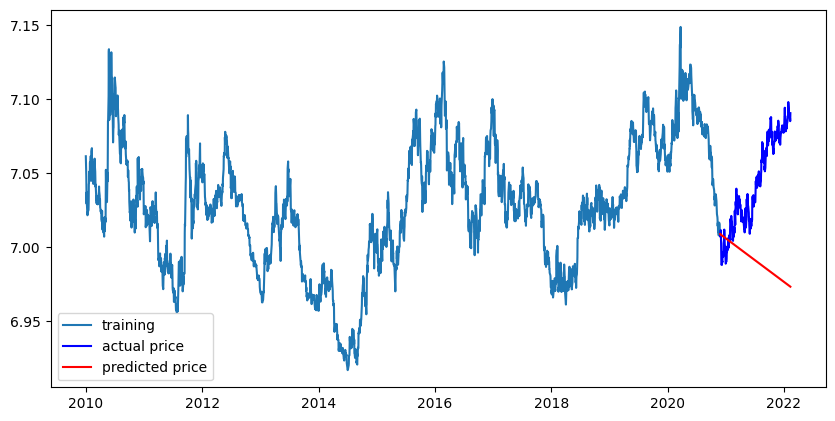

MSE:  5517.479281093237
MAE:  60.78670569398062
RMSE:  74.27973667894385
MAPE: 5.20%


In [102]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2, 2, 2))
fitted_m = model.fit()
print(fitted_m.summary())
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

In [134]:
bio_df = fdr.DataReader('365000', '2015')
er_df = fdr.DataReader('USD/KRW','2015')
kospi_df = fdr.DataReader('310960','2015')
kakao_df = fdr.DataReader('035720','2015')
kosdaq_df = fdr.DataReader('233740','2015')
nifty_df = fdr.DataReader('200250','2015')

In [156]:
all_df = pd.concat([bio_df['Close'],er_df['Close'],kospi_df['Close'],kakao_df['Close'],kosdaq_df['Close'],nifty_df['Close']],axis=1)

In [157]:
all_df.dropna(inplace=True)

In [158]:
all_df.columns = ['bio_close','ER_close','kospi_close','kakao_close','kosdaq_close','nifty_close']

In [162]:
kospi_srs = kospi_df.Close

In [164]:
kospi_srs.isna().sum()

0

In [165]:
log_kospi_srs = np.log(kospi_srs)
log_kospi_srs.head()

Date
2018-11-20    9.511185
2018-11-21    9.505619
2018-11-22    9.504129
2018-11-23    9.495895
2018-11-26    9.511555
Name: Close, dtype: float64

159.4

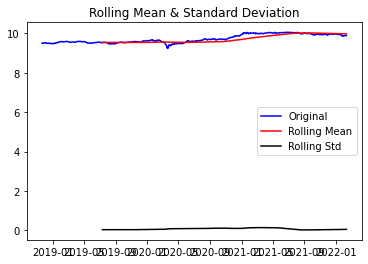

In [169]:
plot_rolling_statistics(log_kospi_srs, window=int(797/5))

In [170]:
augmented_dickey_fuller_test(log_kospi_srs)

Results of Dickey-Fuller Test:
Test Statistic                  -1.075071
p-value                          0.724910
#Lags Used                       2.000000
Number of Observations Used    794.000000
Critical Value (1%)             -3.438613
Critical Value (5%)             -2.865187
Critical Value (10%)            -2.568712
dtype: float64


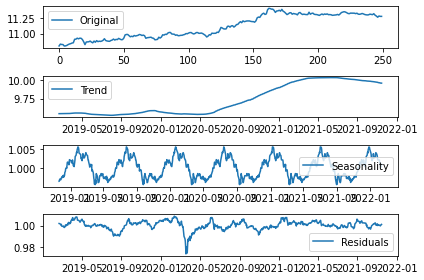

In [172]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_kospi_srs, model='multiplicative',period=120)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(log_close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [173]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.484260
p-value                          0.000210
#Lags Used                       3.000000
Number of Observations Used    673.000000
Critical Value (1%)             -3.440104
Critical Value (5%)             -2.865844
Critical Value (10%)            -2.569062
dtype: float64


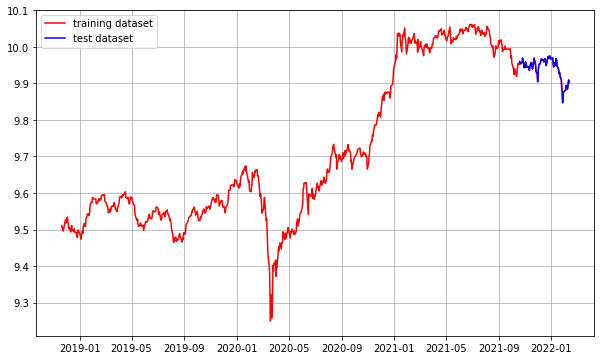

In [174]:
train_data, test_data = log_kospi_srs[:int(len(log_kospi_srs)*0.9)], log_kospi_srs[int(len(log_kospi_srs)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(log_kospi_srs, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


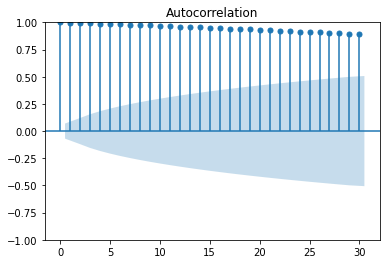

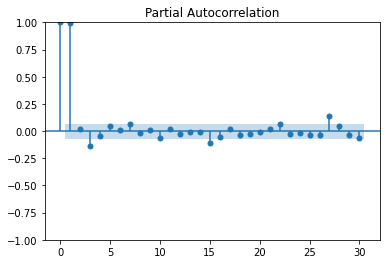

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(log_kospi_srs) #autocorrelation
plot_pacf(log_kospi_srs) #partial autocorrelation
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.785176e+01
p-value                        3.077525e-30
#Lags Used                     1.000000e+00
Number of Observations Used    7.940000e+02
Critical Value (1%)           -3.438613e+00
Critical Value (5%)           -2.865187e+00
Critical Value (10%)          -2.568712e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.251393e+01
p-value                        2.636957e-23
#Lags Used                     1.500000e+01
Number of Observations Used    7.790000e+02
Critical Value (1%)           -3.438772e+00
Critical Value (5%)           -2.865257e+00
Critical Value (10%)          -2.568749e+00
dtype: float64


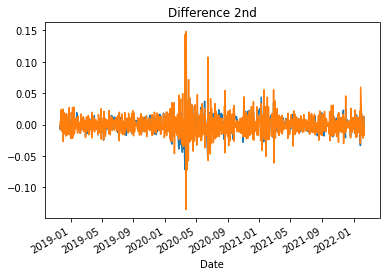

In [176]:
# 1차 차분
diff_1 = log_kospi_srs.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [177]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2, 0, 1))
fitted_m = model.fit()
print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  717
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2073.751
Date:                Fri, 11 Feb 2022   AIC                          -4137.503
Time:                        02:24:02   BIC                          -4114.627
Sample:                             0   HQIC                         -4128.670
                                - 717                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8241   8.82e-08   1.11e+08      0.000       9.824       9.824
ar.L1          0.0026      0.010      0.245      0.806      -0.018       0.023
ar.L2          0.9974      0.010     95.676      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


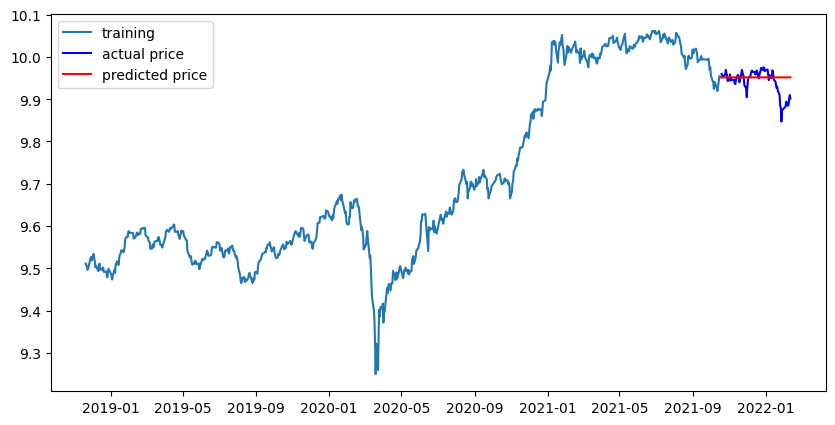

In [178]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [179]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  339780.19484583195
MAE:  396.9604704029838
RMSE:  582.906677647316
MAPE: 1.96%


In [181]:
nifty_srs = nifty_df.Close

In [183]:
nifty_srs.isna().sum()

0

In [184]:
log_nifty_srs = np.log(nifty_srs)

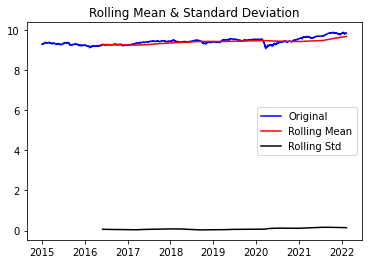

In [185]:
plot_rolling_statistics(log_nifty_srs, window=int(len(log_nifty_srs)/5))

In [186]:
augmented_dickey_fuller_test(log_nifty_srs)

Results of Dickey-Fuller Test:
Test Statistic                   -0.785241
p-value                           0.823419
#Lags Used                       12.000000
Number of Observations Used    1737.000000
Critical Value (1%)              -3.434120
Critical Value (5%)              -2.863205
Critical Value (10%)             -2.567657
dtype: float64


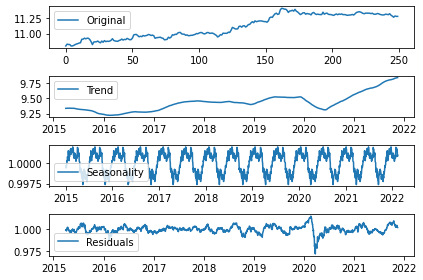

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_nifty_srs, model='multiplicative',period=120)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(log_close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [189]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.109148e+00
p-value                        3.980843e-10
#Lags Used                     1.600000e+01
Number of Observations Used    1.613000e+03
Critical Value (1%)           -3.434411e+00
Critical Value (5%)           -2.863334e+00
Critical Value (10%)          -2.567725e+00
dtype: float64


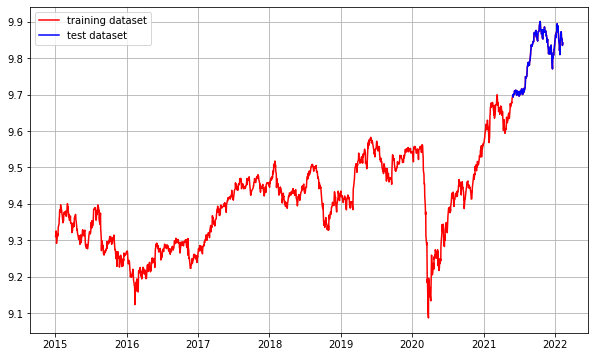

In [191]:
train_data, test_data = log_nifty_srs[:int(len(log_nifty_srs)*0.9)], log_nifty_srs[int(len(log_nifty_srs)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(log_nifty_srs, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


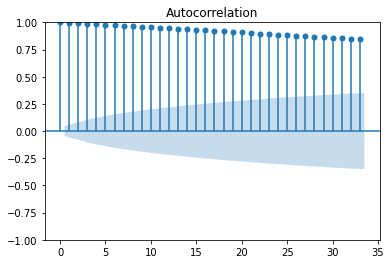

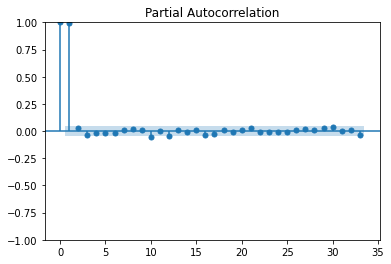

In [192]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(log_nifty_srs) #autocorrelation
plot_pacf(log_nifty_srs) #partial autocorrelation
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.101501e+01
p-value                        6.188250e-20
#Lags Used                     1.100000e+01
Number of Observations Used    1.737000e+03
Critical Value (1%)           -3.434120e+00
Critical Value (5%)           -2.863205e+00
Critical Value (10%)          -2.567657e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.352640e+01
p-value                        2.673291e-25
#Lags Used                     2.500000e+01
Number of Observations Used    1.722000e+03
Critical Value (1%)           -3.434153e+00
Critical Value (5%)           -2.863220e+00
Critical Value (10%)          -2.567664e+00
dtype: float64


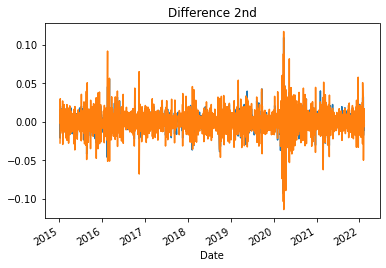

In [216]:
# 1차 차분
diff_1 = log_nifty_srs.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1575
Model:                 ARIMA(0, 2, 1)   Log Likelihood                4783.654
Date:                Fri, 11 Feb 2022   AIC                          -9563.307
Time:                        02:53:59   BIC                          -9552.586
Sample:                             0   HQIC                         -9559.323
                               - 1575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.209     -4.788      0.000      -1.409      -0.591
sigma2         0.0001   2.79e-05      4.758      0.000    7.82e-05       0.000
Ljung-Box (L1) (Q):                   2.13   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


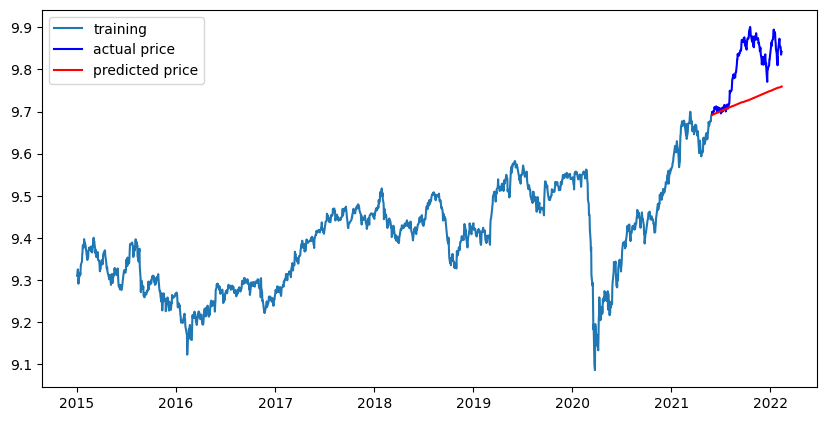

MSE:  2917966.9435218517
MAE:  1410.920721039155
RMSE:  1708.2057673248419
MAPE: 7.46%


In [218]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0, 2, 1))
fitted_m = model.fit()
print(fitted_m.summary())
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# 실험종료  
실험에는 총 3가지 예측이 시도되었다
달러 환율, kospi, nifty 지수에 대한 값이었다  
달러는 10년, kospi와 nifty는 5년에 대해서 시계열 자료를 사용하였다
여기에서 사용된 모든 데이터들은 모두 ACF, PACF 사용결과 AR형태를 따르는 형태로 발견되었고 이에따라 p + q < 2, p * q = 0 의 이상적인 값안에서 설정되었음  
물론 그렇게 설정하지 않았던 값도 있는데 이는 어떠한 현상이 일어나는지 확인하고자 하는 형태로 표현하였음  
따라서 여기에서 실험한 모델들은 모두 q=1이 되어야하는 형태가 핵심  
차분은 마지막 nifty에서는 차분의 결과가 매우 두드러져서 정상성 확보에 다소 어려움이 있었던 것으로 보이기도 한다  
대체로 경향성은 맞은 듯한데 그래도 저 선을 제대로 따라가지 못하는 부분은 아쉽다